# Uploading Files

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
BASE_PATH = "/content/drive/MyDrive/UIDAI"


In [3]:
import pandas as pd

enroll = pd.read_csv(f"{BASE_PATH}/aadhaar_enrolment_cleaned.csv")
demo1 = pd.read_csv(f"{BASE_PATH}/aadhaar_demography_part_1.csv")
demo2 = pd.read_csv(f"{BASE_PATH}/aadhaar_demography_part_2.csv")

In [4]:
demo = pd.concat([demo1, demo2], ignore_index = True)

#Showing Columns of Aadhar Enrollment and Demographic Data

In [5]:
print(enroll.columns)
print(demo.columns)

Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')
Index(['date', 'state', 'pincode', 'demo_age_5_17', 'demo_age_17_',
       'district'],
      dtype='object')


#Preprocessing of Demographic Data for Merging

In [6]:
demo.head()

,date,state,pincode,demo_age_5_17,demo_age_17_,district
0,01-03-2025,Uttar Pradesh,273213,49,529,Gorakhpur
1,01-03-2025,Andhra Pradesh,517132,22,375,Chittoor
2,01-03-2025,Gujarat,360006,65,765,Rajkot
3,01-03-2025,Andhra Pradesh,532484,24,314,Srikakulam
4,01-03-2025,Rajasthan,313801,45,785,Udaipur


**Renaming columns to keep similarity with Aadhar Enrollment Data**

In [7]:
demo.rename(columns={"demo_age_17_": "demo_age_18_greater"}, inplace=True)


**Converting Date Column as per the Standard Norms**

In [8]:
enroll['date'] = pd.to_datetime(enroll['date'], dayfirst = True)
demo['date'] = pd.to_datetime(demo['date'], dayfirst = True)

#Merging Aadhar Enrollment and Demographic Data

In [9]:
merged = pd.merge(
    enroll,
    demo,
    on=["date", "state", "district", "pincode"],
    how="outer"
)


**Printing the Columns of Merged Dataset**

In [10]:
print(merged.columns)

Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater', 'demo_age_5_17', 'demo_age_18_greater'],
      dtype='object')


# Create educational features

**Total Enrollment**

In [11]:
merged["Total_Enrollment"] = merged["age_0_5"] + merged["age_5_17"] + merged["age_18_greater"]

**Total Demographic Updates**

In [12]:
merged["Total_Demo_Updates"] = (
    merged["demo_age_5_17"] + merged["demo_age_18_greater"]
)


**Youth Ratio**

In [13]:
merged["youth_ratio"] = merged["age_5_17"]/merged["Total_Enrollment"]

**Child Ratio**

In [14]:
merged["child_ratio"] = merged["age_0_5"] / merged["Total_Enrollment"]


**Demo Update Ratio**

In [15]:
merged["demo_update_ratio"] = merged["demo_age_5_17"] / merged["Total_Demo_Updates"]


#Merging biometric data

In [16]:
bio1 = pd.read_csv(f"{BASE_PATH}/biometric_part1.csv")
bio2 = pd.read_csv(f"{BASE_PATH}/biometric_part2.csv")

In [17]:
biometric = pd.concat([bio1, bio2], ignore_index = True)

In [18]:
print(biometric.columns)

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')


**Biometric Data Preprocessing**

In [19]:
biometric.rename(columns={
    'bio_age_5_17': 'biometric_age_5_17',
    'bio_age_17_': 'biometric_age_18_greater'
}, inplace=True)


In [20]:
biometric['date'] = pd.to_datetime(
    biometric['date'],
    dayfirst=True,
    errors='coerce'
)



In [21]:
biometric['date'].isna().sum()


np.int64(0)

In [22]:
biometric = biometric.dropna(subset=['date'])


#Merging Biometric data to other datasets

In [23]:
merged = pd.merge(
    merged,
    biometric,
    on=["date", "state", "district", "pincode"],
    how="left"
)

#Create Biometric Indicators

**Total Biometric Updates**

In [24]:
merged['Total_Biometric_Updates'] = (
    merged['biometric_age_5_17'] +
    merged['biometric_age_18_greater']
)


In [25]:
merged['biometric_update_ratio'] = (
    merged['biometric_age_5_17'] /
    merged['Total_Biometric_Updates']
)

#Applying ML

**Fixing Biometric Data**

In [38]:

biometric.groupby(['state','district'])['biometric_age_5_17'].sum().describe()


,biometric_age_5_17
count,961.000000
mean,35615.874089
std,39730.996274
min,0.000000
25%,3169.000000
50%,23598.000000
75%,53657.000000
max,283480.000000


**Aggregate Each Dataset Separately**

*Enrollment*

In [39]:
enroll_dist = (
    enroll
    .groupby(['state','district'], as_index=False)
    .agg({
        'age_0_5':'sum',
        'age_5_17':'sum',
        'age_18_greater':'sum'
    })
)

enroll_dist['Total_Enrollment'] = (
    enroll_dist['age_0_5'] +
    enroll_dist['age_5_17'] +
    enroll_dist['age_18_greater']
)


*Demographic*

In [40]:
demo_dist = (
    demo
    .groupby(['state','district'], as_index=False)
    .agg({
        'demo_age_5_17':'sum'
    })
)


*Biometric*

In [42]:
bio_dist = (
    biometric
    .groupby(['state','district'], as_index=False)
    .agg({
        'biometric_age_5_17':'sum'
    })
)


**Merge Aggregated Datasets**

In [44]:
district_final = (
    enroll_dist
    .merge(demo_dist, on=['state','district'], how='left')
    .merge(bio_dist, on=['state','district'], how='left')
)

district_final[['demo_age_5_17','biometric_age_5_17']] = (
    district_final[['demo_age_5_17','biometric_age_5_17']].fillna(0)
)


**Compute Ratios**

In [45]:
district_final['youth_ratio'] = (
    district_final['age_5_17'] / district_final['Total_Enrollment']
)

district_final['demo_update_ratio'] = (
    district_final['demo_age_5_17'] / district_final['Total_Enrollment']
)

district_final['biometric_update_ratio'] = (
    district_final['biometric_age_5_17'] / district_final['Total_Enrollment']
)

district_final[['youth_ratio','demo_update_ratio','biometric_update_ratio']] = (
    district_final[['youth_ratio','demo_update_ratio','biometric_update_ratio']]
    .fillna(0)
)


In [46]:
district_final.shape
district_final['district'].duplicated().sum()
district_final[['youth_ratio','demo_update_ratio','biometric_update_ratio']].describe()


,youth_ratio,demo_update_ratio,biometric_update_ratio
count,876.000000,876.000000,876.000000
mean,0.263445,1.260964,0.040799
std,0.180611,2.045843,0.545077
min,0.000000,0.000000,0.000000
25%,0.126073,0.533625,0.000000
50%,0.222495,0.901912,0.000000
75%,0.371019,1.426572,0.000000
max,1.000000,33.000000,11.035559


**Applying Capping**

In [47]:
# Cap ratios at logical maximum
district_final['demo_update_ratio'] = district_final['demo_update_ratio'].clip(upper=1)
district_final['biometric_update_ratio'] = district_final['biometric_update_ratio'].clip(upper=1)


In [48]:
district_final[['youth_ratio',
                'demo_update_ratio',
                'biometric_update_ratio']].describe()


,youth_ratio,demo_update_ratio,biometric_update_ratio
count,876.000000,876.000000,876.000000
mean,0.263445,0.739549,0.007042
std,0.180611,0.322574,0.082705
min,0.000000,0.000000,0.000000
25%,0.126073,0.533625,0.000000
50%,0.222495,0.901912,0.000000
75%,0.371019,1.000000,0.000000
max,1.000000,1.000000,1.000000


**Compute Educational Engagement Index(EEI)**

In [49]:
district_final['Education_Engagement_Index'] = (
    0.45 * district_final['youth_ratio'] +
    0.30 * district_final['demo_update_ratio'] +
    0.25 * district_final['biometric_update_ratio']
)


**Applying K-Means Clustering**

In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = district_final[
    ['youth_ratio','demo_update_ratio','biometric_update_ratio']
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
district_final['Education_Cluster'] = kmeans.fit_predict(X_scaled)


**Cluster Interpretation**

In [51]:
cluster_profile = (
    district_final
    .groupby('Education_Cluster')[[
        'Education_Engagement_Index',
        'youth_ratio',
        'demo_update_ratio',
        'biometric_update_ratio'
    ]]
    .mean()
    .round(3)
)

cluster_profile


,Education_Engagement_Index,youth_ratio,demo_update_ratio,biometric_update_ratio
Education_Cluster,,,,
0,0.196,0.266,0.254,0.001
1,0.351,0.153,0.940,0.000
2,0.457,0.507,0.764,0.000
3,0.606,0.296,0.744,1.000


**Percentile-Based Risk Thresholds**

In [52]:
p10 = district_final['Education_Engagement_Index'].quantile(0.10)
p50 = district_final['Education_Engagement_Index'].quantile(0.50)
p85 = district_final['Education_Engagement_Index'].quantile(0.85)

def education_status_policy(score):
    if score <= p10:
        return "Critical – Severe Education Exclusion"
    elif score <= p50:
        return "Low Education Engagement"
    elif score <= p85:
        return "Moderate Education Engagement"
    else:
        return "High Education Engagement"

district_final['Education_Status'] = (
    district_final['Education_Engagement_Index']
    .apply(education_status_policy)
)


**Final Validation**

In [53]:
# One row per district
district_final['district'].duplicated().sum()


district_final[['youth_ratio',
                'demo_update_ratio',
                'biometric_update_ratio']].describe()


district_final['Education_Status'].value_counts(normalize=True) * 100


,proportion
Education_Status,
Low Education Engagement,39.954338
Moderate Education Engagement,34.931507
High Education Engagement,15.068493
Critical – Severe Education Exclusion,10.045662


**Save the Final Output**

In [54]:
district_final.to_csv(
    "FINAL_district_education_engagement_policy_ready.csv",
    index=False
)


# Visualization

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("FINAL_district_education_engagement_policy_ready.csv")


**VISUAL - 1 -- State-wise Education Engagement**

*Aggregate Districts*

In [62]:
state_status = (
    df
    .groupby(['state', 'Education_Status'])
    .size()
    .reset_index(name='District_Count')
)

*Visualising Bar Chart of Needing Critical Education Campaigns in the Districts for each State*

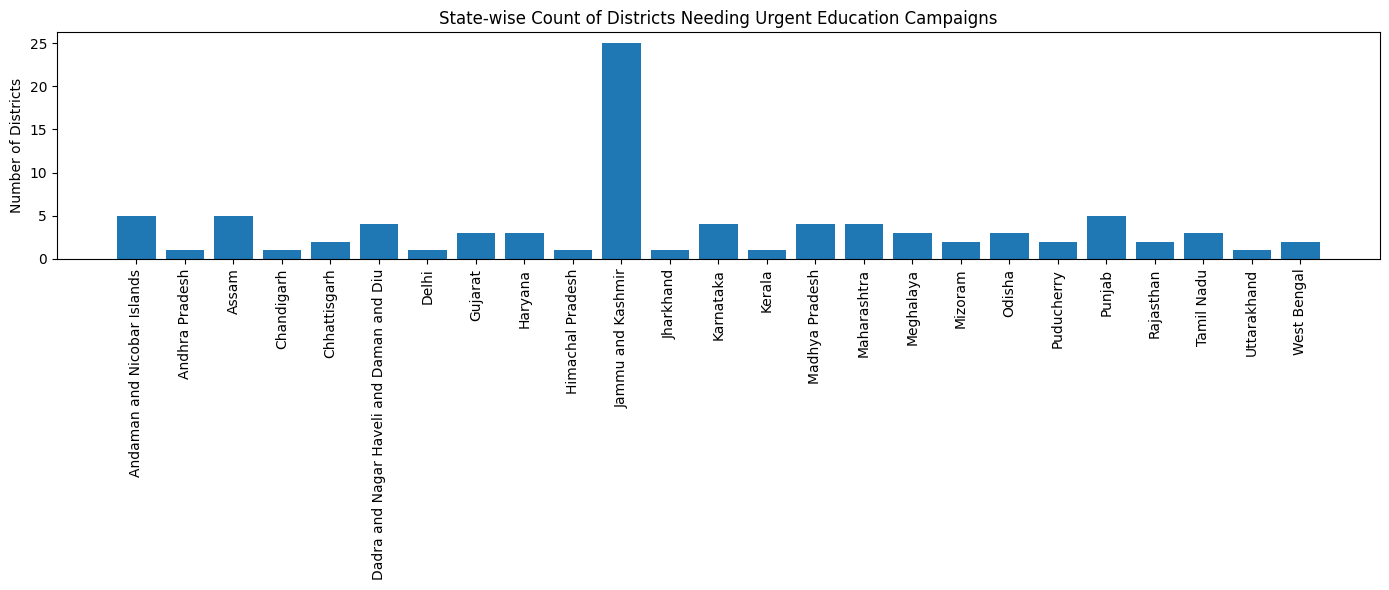

In [63]:
critical_state = state_status[
    state_status['Education_Status'] == "Critical – Severe Education Exclusion"
]

plt.figure(figsize=(14,6))
plt.bar(
    critical_state['state'],
    critical_state['District_Count']
)

plt.xticks(rotation=90)
plt.ylabel("Number of Districts")
plt.title("State-wise Count of Districts Needing Urgent Education Campaigns")
plt.tight_layout()
plt.show()


**Visual 2 -- Distribution of Education Status**

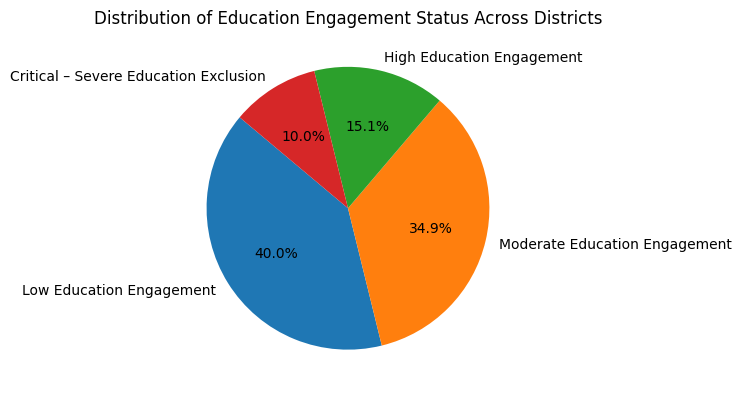

In [64]:
status_counts = df['Education_Status'].value_counts()

# Pie chart
plt.figure(figsize=(7,7))
plt.pie(
    status_counts.values,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=140
)

plt.title("Distribution of Education Engagement Status Across Districts")
plt.tight_layout()
plt.show()


 **Visual 3 -- Top 10 vs Bottom 10 Districts by Education Engagement Index**

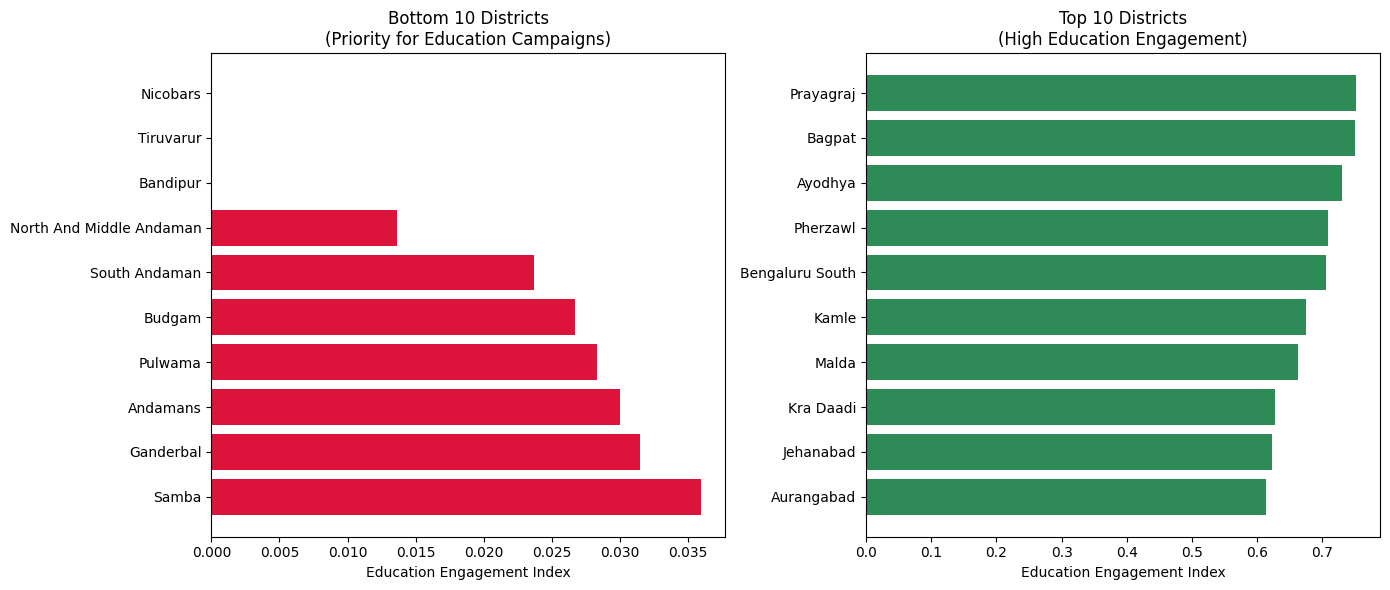

In [65]:
top10 = df.sort_values(
    'Education_Engagement_Index',
    ascending=False
).head(10)

bottom10 = df.sort_values(
    'Education_Engagement_Index'
).head(10)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# Bottom 10
axes[0].barh(
    bottom10['district'],
    bottom10['Education_Engagement_Index'],
    color='crimson'
)
axes[0].set_title("Bottom 10 Districts\n(Priority for Education Campaigns)")
axes[0].set_xlabel("Education Engagement Index")
axes[0].invert_yaxis()

# Top 10
axes[1].barh(
    top10['district'],
    top10['Education_Engagement_Index'],
    color='seagreen'
)
axes[1].set_title("Top 10 Districts\n(High Education Engagement)")
axes[1].set_xlabel("Education Engagement Index")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


**Visual 4 -- Why District are Weak**

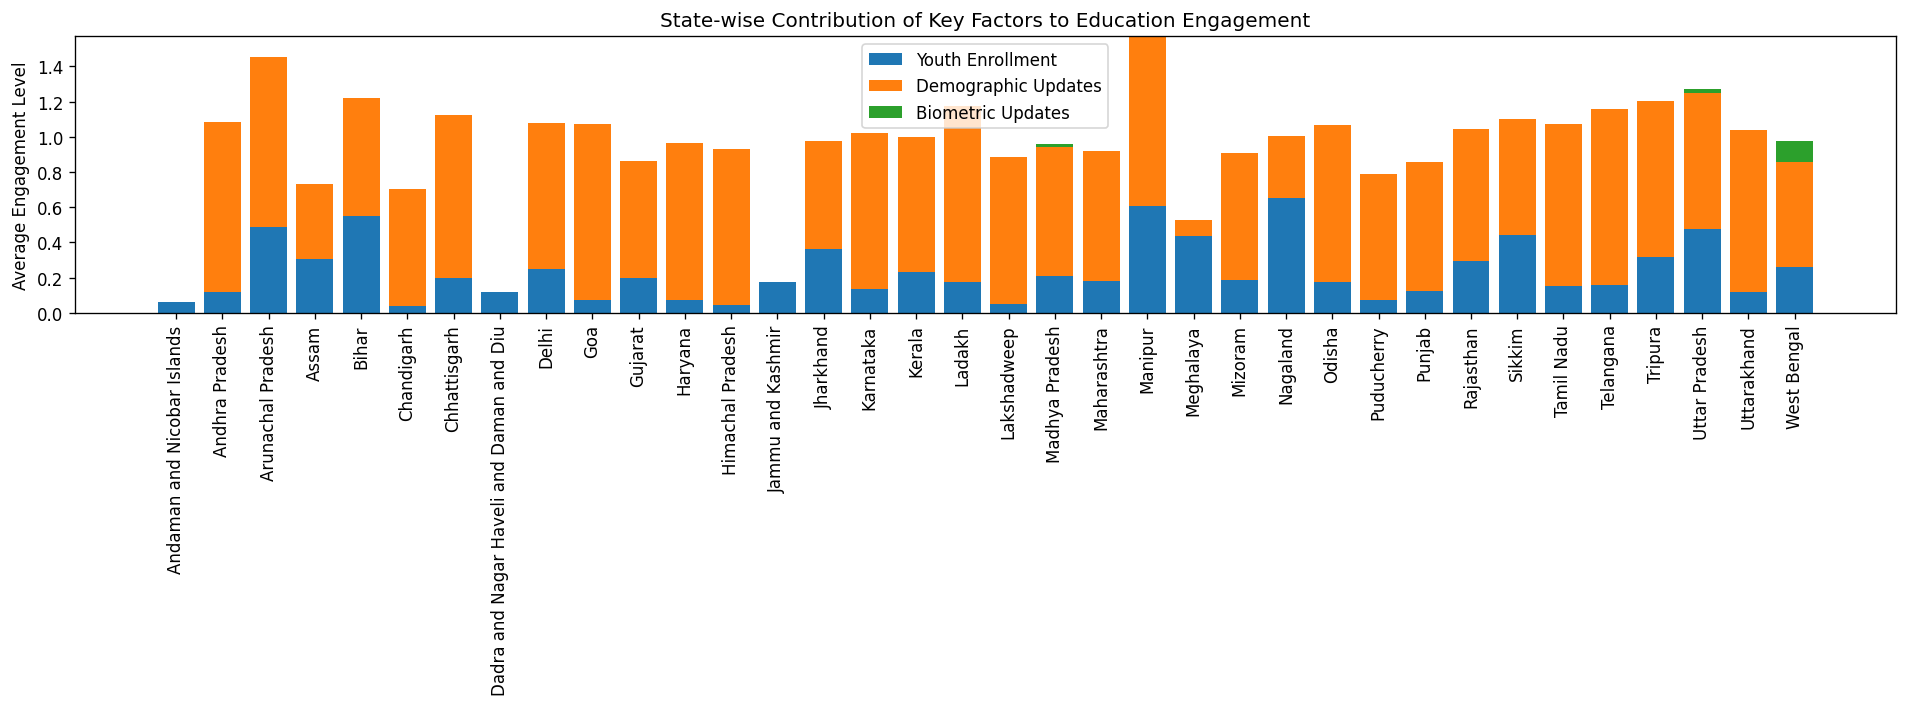

In [70]:
# Aggregate to State Level
state_level = (
    df
    .groupby('state')[[
        'youth_ratio',
        'demo_update_ratio',
        'biometric_update_ratio'
    ]]
    .mean()
    .reset_index()
)

# State-wise Stacked Bar Chart

plt.figure(figsize=(16,6), dpi=120)

plt.bar(
    state_level['state'],
    state_level['youth_ratio'],
    label='Youth Enrollment'
)

plt.bar(
    state_level['state'],
    state_level['demo_update_ratio'],
    bottom=state_level['youth_ratio'],
    label='Demographic Updates'
)

plt.bar(
    state_level['state'],
    state_level['biometric_update_ratio'],
    bottom=state_level['youth_ratio'] + state_level['demo_update_ratio'],
    label='Biometric Updates'
)

plt.xticks(rotation=90)
plt.ylabel("Average Engagement Level")
plt.title("State-wise Contribution of Key Factors to Education Engagement")
plt.legend()
plt.tight_layout()
plt.show()


**Visual-4 -- ML Cluster Visualisation**

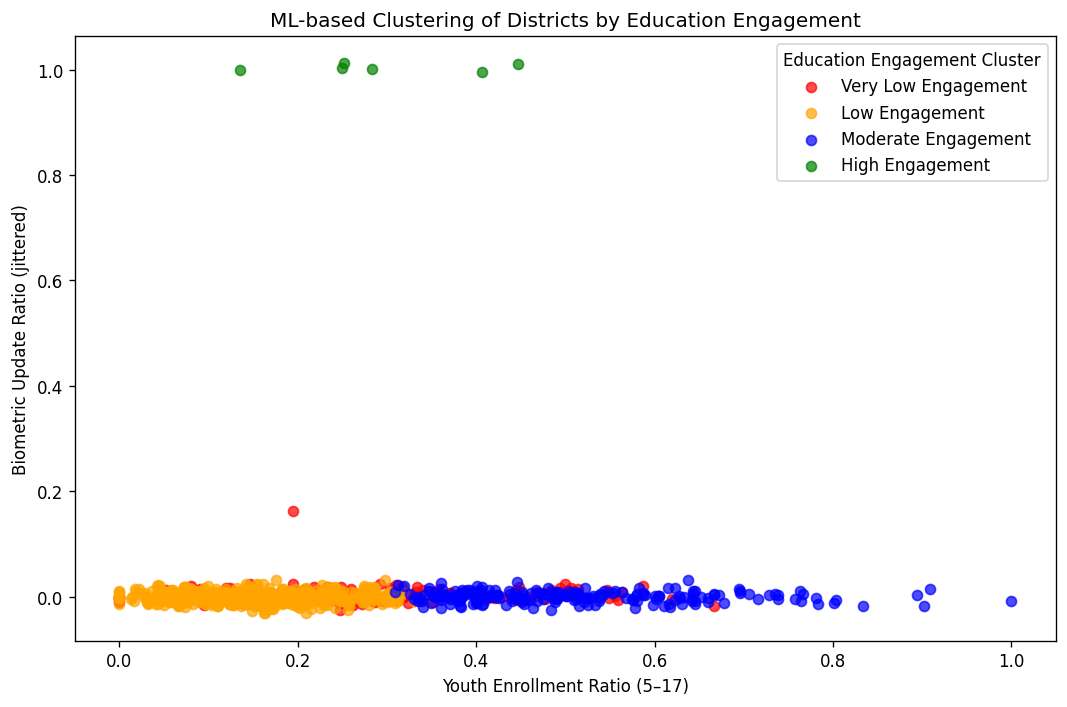

In [73]:
# Define Cluster Labels
cluster_labels = {
    0: "Very Low Engagement",
    1: "Low Engagement",
    2: "Moderate Engagement",
    3: "High Engagement"
}

# Add jitter(for visibility)
import numpy as np

y_jitter = df['biometric_update_ratio'] + np.random.normal(0, 0.01, size=len(df))


# Scatter plot
plt.figure(figsize=(9,6), dpi=120)

colors = {
    0: 'red',
    1: 'orange',
    2: 'blue',
    3: 'green'
}

for cluster_id, label in cluster_labels.items():
    subset = df[df['Education_Cluster'] == cluster_id]

    plt.scatter(
        subset['youth_ratio'],
        y_jitter[subset.index],
        color=colors[cluster_id],
        alpha=0.7,
        label=label
    )

plt.xlabel("Youth Enrollment Ratio (5–17)")
plt.ylabel("Biometric Update Ratio (jittered)")
plt.title("ML-based Clustering of Districts by Education Engagement")

plt.legend(title="Education Engagement Cluster")
plt.tight_layout()
plt.show()





**Visual-6 -- Cluster-wise Education Profile**

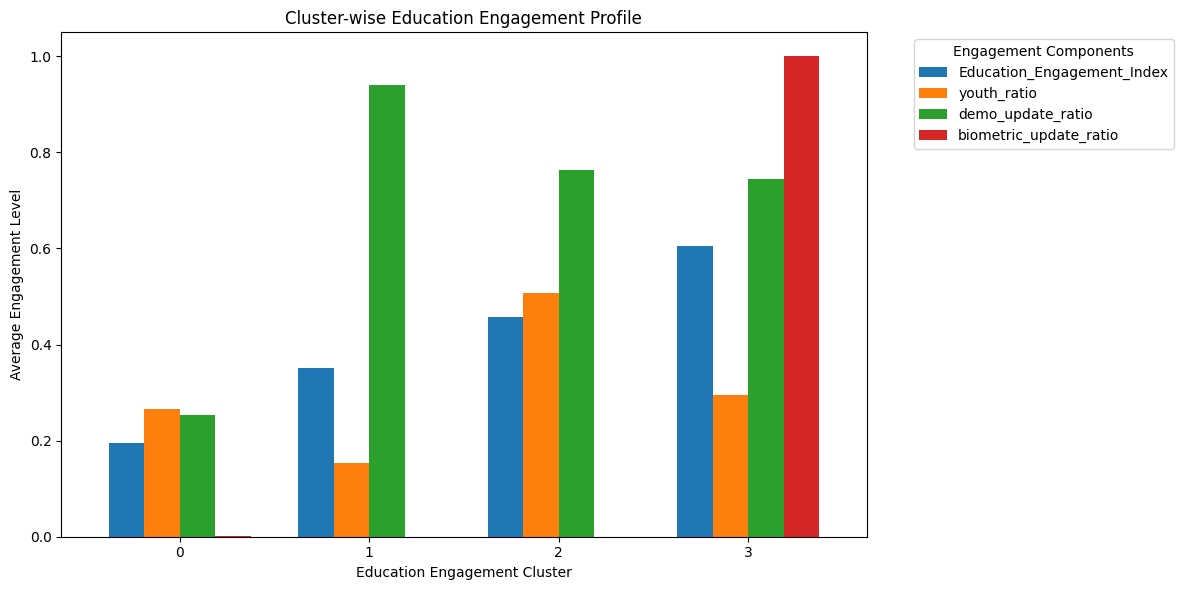

In [74]:
import matplotlib.pyplot as plt

cluster_profile.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.75
)

plt.title("Cluster-wise Education Engagement Profile")
plt.ylabel("Average Engagement Level")
plt.xlabel("Education Engagement Cluster")
plt.xticks(rotation=0)
plt.legend(
    title="Engagement Components",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()
